In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Item Rando:
# 26 'randomizeable' items
# 100 'randomizeable' drop locations
# idea 1: location : item_id
# ~ 500 bits (locations * log(items))
# idea 2: item : location_id
# ~ 700 bits (locations * log(locations))
# idea 3: location : common_item_id
# major_item : location_id
# 300 bits + 126 bits

In [3]:
# Door Rando:
# ~550 doors
# idea 1: door: door_id
# 550 * log(550) = 5500 bits
# idea 2: left_door : right_door_id
# top_door : bottom_door_id
# 225 * log(225) = 2040
# idea 3:
# X, Y
# overworld is ~ 128 x 128
# 14 bits per room * 255 rooms = 3570

In [4]:
import sys
sys.path.append("../..")

In [5]:
from encoding.parse_rooms import parse_rooms, parse_exits, dictify_rooms

In [6]:
from functools import cache
from itertools import combinations

In [7]:
from rom_tools.rom_manager import RomManager
from abstraction_validation.sm_paths import *

In [8]:
from bdds.bdd_core import *
from bdds.node_bdds import *
from bdds.design_conditioned import *

In [9]:
from functools import reduce

In [10]:
helper = DesignInfo("../../encoding/dsl/rooms_for_alloy.txt", "../../encoding/dsl/exits_for_alloy.txt", "../../output/important_closure.dddmp")

In [11]:
context = helper.context

In [12]:
#TODO: still need this?
next_to_prev = mk_replace(context, "next", "prev")
nexts = [k for k in context.vars.keys() if k.endswith("_next")]
prevs = [k for k in context.vars.keys() if k.endswith("_prev")]

In [13]:
(helper.trans_important & helper.binary_to_one_hot).dag_size, helper.trans_important.dag_size

(337284, 289590)

In [14]:
trans_one_hot = helper.context.exist(["node_id_prev", "node_id_next"], helper.trans_important & helper.binary_to_one_hot)

In [15]:
trans_one_hot.dag_size

297968

In [16]:
helper.binary_to_one_hot = mk_binary_to_one_hot(helper.context, helper.important_nodes, helper.node_ids)

In [17]:
helper.binary_to_one_hot.dag_size

26884

In [18]:
helper.binary_to_one_hot.count() # Should be 30^2 = 900

900.0

In [19]:
#TODO: still need this
def mk_one_hot(trans):
    return context.exist(["node_id_prev", "node_id_next"], trans & helper.binary_to_one_hot)

In [20]:
from tqdm.notebook import tqdm

In [21]:
# Compute the design UNCONDITIONAL item-item reachability transes

In [22]:
items_unchanged = context.add_expr("items_unchanged", with_ops=True)
item_nexts = [k for k in item_vars if k.endswith("_next")]
item_prevs = [k for k in item_vars if k.endswith("_prev")]

In [23]:
#TODO: proposed method for deriving nuisance variables
#bad_items = []
#for i in design["Items"] | design["Bosses"]:
#    istr = f"{i}_prev"
#    i_without = context.add_expr(f"{istr} = 0")
#    i_with = context.add_expr(f"{istr} = 1")
#    if context.exist([istr], (trans & i_without)) == context.exist([istr], (trans & i_with)):
#        bad_items.append(i)

In [24]:
#context.bdd.dump("../../output/important_closure.dddmp", [trans_important])

In [25]:
trans_item, trans_important, teleport_trans = helper.trans_item, helper.trans_important, helper.teleport_trans

In [26]:
teleport_one_hot = mk_one_hot(teleport_trans)

In [27]:
trans_item.dag_size, trans_important.dag_size, teleport_trans.dag_size

(28036, 289590, 327752)

In [28]:
from data_types import item_set

In [29]:
def find_reachable_special(start_bdd):
    n = 0
    reachable = start_bdd
    reachable_last = context.false
    while reachable != reachable_last:
        reachable_last = reachable
        # one teleport step
        reachable |= context.let(next_to_prev, context.exist(prevs, reachable & trans_important))
        # one item step
        reachable |= context.let(next_to_prev, context.exist(prevs, reachable & trans_item))
        print(n, reachable.dag_size)
        n += 1
    return reachable

In [30]:
item_next_to_prev = {k:v for k,v in next_to_prev.items() if k != "node_id_next"}

In [31]:
# TODO: derive these sets using forall
trans_majors = major_items + list(helper.design["Bosses"].keys())
trans_minors = ["node_id"] + minor_items
minor_nexts = [f"{i}_next" for i in trans_minors]
minor_prevs = [f"{i}_prev" for i in trans_minors]
major_nexts = [f"{i}_next" for i in trans_majors]
major_prevs = [f"{i}_prev" for i in trans_majors]
minor_ntp = {f"{i}_next" : f"{i}_prev" for i in trans_minors}
major_ntp = {f"{i}_next" : f"{i}_prev" for i in trans_majors}
assert set(major_nexts) & set(minor_nexts) == set()
#assert set(major_nexts) | set(minor_nexts) == set(item_nexts + ["node_id_next"])

In [32]:
def find_reachable_special2(start_bdd):
    n = 0
    # Record the intermediate swell
    iswell = 0
    #trans_important_partial = context.exist(item_nexts, trans_important)
    #trans_item_partial = context.exist(["node_id_next"], trans_item)
    trans_important_partial = context.exist(major_nexts, trans_important)
    trans_item_partial = context.exist(minor_nexts, trans_item)
    reachable = start_bdd
    reachable_last = context.false
    while reachable != reachable_last:
        reachable_last = reachable
        # one teleport step
        #reachable |= context.let({"node_id_next": "node_id_prev"}, context.exist(["node_id_prev"], reachable & trans_important_partial))
        reachable |= context.let(minor_ntp, context.exist(minor_prevs, reachable & trans_important_partial))
        # one item step
        #reachable |= context.let(item_next_to_prev, context.exist(item_prevs, reachable & trans_item_partial))
        reachable |= context.let(major_ntp, context.exist(major_prevs, reachable & trans_item_partial))
        dag_size = reachable.dag_size
        print(n, dag_size)
        if dag_size > iswell:
            iswell = dag_size
        n += 1
    return reachable, iswell

In [33]:
def find_reachable_special_hints(start_bdd, hints=[]):
    reachable = start_bdd
    hints.append(context.true)
    for h,hint in enumerate(hints):
        n = 0
        trans_important_partial = context.exist(major_nexts, trans_important & hint)
        trans_item_partial = context.exist(minor_nexts, trans_item & hint)
        reachable_last = context.false
        while reachable != reachable_last:
            reachable_last = reachable
            # one teleport step
            reachable |= context.let(minor_ntp, context.exist(minor_prevs, reachable & trans_important_partial))
            # one item step
            reachable |= context.let(major_ntp, context.exist(major_prevs, reachable & trans_item_partial))
            print(h, n, reachable.dag_size)
            n += 1
    return reachable

In [34]:
def get_item_vars(var_list):
    return list(filter(lambda x: (not x.startswith("at")) and (not x.startswith("node_id")), var_list))

In [35]:
def get_ats(var_list):
    return list(filter(lambda x: x.startswith("at"), var_list))

In [36]:
# Set of all prevs without node_id_prev -- these are "item state"
item_vars_p = get_item_vars(prevs)
item_vars_pn = get_item_vars(prevs) + get_item_vars(nexts)
loc_vars_p = get_ats(prevs)
loc_vars_pn = get_ats(prevs) + get_ats(nexts)

In [37]:
def find_reachable_cartesian(start_bdd):
    n = 0
    # Record the intermediate swell
    iswell = 0
    reachable_locs = context.exist(item_vars_p + nexts, start_bdd)
    reachable_items = context.exist(["node_id_prev"] + nexts, start_bdd)
    reachable_locs_last = context.false
    reachable_items_last = context.false
    while reachable_items != reachable_items_last or reachable_locs != reachable_locs_last:
        reachable_items_last = reachable_items
        reachable_locs_last = reachable_locs
        reachable_locs = context.let(next_to_prev, context.exist(prevs, reachable_locs & context.exist(item_vars_pn, reachable_items & teleport_trans)))
        reachable_items = context.let(next_to_prev, context.exist(prevs, reachable_items & context.exist(["node_id_prev", "node_id_next"], reachable_locs & teleport_trans)))
        dag_size = reachable_locs.dag_size + reachable_items.dag_size
        if dag_size > iswell:
            iswell = dag_size
        print(n, dag_size, reachable_locs.dag_size, reachable_items.dag_size)
        n += 1
    return reachable_locs & reachable_items, iswell

In [38]:
def find_reachable_cartesian_one_hot(start_bdd):
    n = 0
    # Record the intermediate swell
    iswell = 0
    reachable_locs = context.exist(item_vars_p + nexts, start_bdd)
    reachable_items = context.exist(loc_vars_p + nexts, start_bdd)
    reachable_locs_last = context.false
    reachable_items_last = context.false
    while reachable_items != reachable_items_last or reachable_locs != reachable_locs_last:
        reachable_items_last = reachable_items
        reachable_locs_last = reachable_locs
        reachable_locs = context.let(next_to_prev, context.exist(prevs, reachable_locs & context.exist(item_vars_pn, reachable_items & teleport_one_hot)))
        reachable_items = context.let(next_to_prev, context.exist(prevs, reachable_items & context.exist(loc_vars_pn, reachable_locs & teleport_one_hot)))
        #reachable_locs = context.let(next_to_prev, context.exist(prevs, reachable_locs & context.exist(item_vars_pn, reachable_items & trans)))
        #reachable_items = context.let(next_to_prev, context.exist(prevs, reachable_items & context.exist(["node_id_prev", "node_id_next"], reachable_locs & trans)))
        dag_size = reachable_locs.dag_size + reachable_items.dag_size
        if dag_size > iswell:
            iswell = dag_size
        print(n, dag_size, reachable_locs.dag_size, reachable_items.dag_size)
        n += 1
    return reachable_locs & reachable_items, iswell

In [39]:
def find_reachable_rounding(start_bdd):
    n = 0
    # Record the intermediate swell
    iswell = 0
    #trans_important_partial = context.exist(item_nexts, trans_important)
    #trans_item_partial = context.exist(["node_id_next"], trans_item)
    trans_important_partial = context.exist(major_nexts, trans_important)
    trans_item_partial = context.exist(minor_nexts, trans_item)
    reachable = start_bdd
    reachable_last = context.false
    while reachable != reachable_last:
        reachable_last = reachable
        # one teleport step
        #reachable |= context.let({"node_id_next": "node_id_prev"}, context.exist(["node_id_prev"], reachable & trans_important_partial))
        reachable |= context.let(minor_ntp, context.exist(minor_prevs, reachable & trans_important_partial))
        # one item step
        #reachable |= context.let(item_next_to_prev, context.exist(item_prevs, reachable & trans_item_partial))
        reachable |= context.let(major_ntp, context.exist(major_prevs, reachable & trans_item_partial))
        locs = context.exist(item_vars, reachable)
        isets = context.exist(["node_id_prev"], reachable)
        reachable |= locs & isets
        dag_size = reachable.dag_size
        print(n, dag_size)
        if dag_size > iswell:
            iswell = dag_size
        n += 1
    return reachable, iswell

In [40]:
start_bdd = context.add_expr("node_id_prev = 0 & at_Landing_Site_Ship_prev = 1") & helper.mk_itemset_expr(item_set.ItemSet())

In [41]:
trans_important_partial = context.exist(major_nexts, trans_important)
trans_item_partial = context.exist(minor_nexts, trans_item)

In [42]:
s2 = start_bdd & trans_important_partial
#s2 = context.exist(minor_nexts, start_bdd & trans_important_partial)
#s2 = context.let(minor_ntp, context.exist(minor_nexts, start_bdd & trans_important_partial))

In [43]:
max_distance = 5
edit_distance = helper.mk_edit_distance(max_distance)
edit_distance_equal = helper.mk_edit_distance(max_distance, "=")

In [48]:
# Check whether highest edit distance is always the worst case by sweeping over eD in a more restricted context
# e.g. only randomizing the first n items
n_restricted = 1
n_un = len(helper.major_drop_nodes) - n_restricted
restricted_nodes = helper.major_drop_nodes[n_un:]
design_restriction = context.true
for room_name, room in helper.design["Rooms"].items():
    for node_name, d in room["Drops"].items():
        name = room_name + "_" + node_name
        if d in major_items:
            if name in restricted_nodes:
                design_restriction &= context.add_expr(f"major_drop_{name} = {major_items.index(d)}")

In [49]:
import time

In [50]:
# Compatible with both one-hot and multi-hot nodes
end_reachable = context.add_expr("node_id_prev = 1 & at_Landing_Site_End_prev = 1")

In [51]:
#reachable, iswell = find_reachable_cartesian(start_bdd & helper.valid_design & edit_distance & design_restriction)
#reachable, iswell = find_reachable_special2(start_bdd & helper.valid_design & edit_distance & design_restriction)

In [55]:
def print_sol(sol):
    for k,v in sol.items():
        if v == 1:
            print(k)

In [60]:
# Compute all randomizations without changing space jump
%%time
reachable, iswell = find_reachable_special2(start_bdd & helper.valid_design & design_restriction)

0 1010962
1 1011891
2 1410139
3 1941194
4 3600055
5 6361910
6 9975773
7 14928585
8 18336375
9 22651147
10 29308017
11 37425047
12 45264720
13 52480380
14 57267867
15 56231480
16 49902410
17 43784412
18 39360309
19 35621199
20 33808238
21 33808238
CPU times: user 52min, sys: 14.2 s, total: 52min 14s
Wall time: 52min 2s


In [58]:
times = []
dag_sizes = []
swells = []
#for ed in tqdm(range(n_un)):
#for ed in tqdm(range(7)):
for ed in [16]:
    edit_distance = helper.mk_edit_distance(ed)
    #tick = time.time()
    #reachable, iswell = find_reachable_cartesian(start_bdd & valid_design & edit_distance & design_restriction)
    #good_designs = context.exist(nexts + prevs, reachable & end_reachable)
    #tock = time.time()
    #times.append(tock - tick)
    tick = time.time()
    #reachable, iswell = find_reachable_special2(start_bdd & helper.valid_design & edit_distance & design_restriction & good_designs)
    reachable = find_reachable_sbfs(teleport_trans, start_bdd & valid_design & edit_distance & design_restriction)
    tock = time.time()
    times.append(tock - tick)
    dag_sizes.append(reachable.dag_size)
    swells.append(iswell)

NameError: name 'valid_design' is not defined

In [50]:
reachable = context.exist(nexts, reachable)

In [51]:
reachable.dag_size

90820

In [52]:
# ED7 approx: 464586

In [53]:
context.exist(helper.design_vars.keys(), reachable).dag_size

1795

In [229]:
locs = context.exist(item_vars, reachable)
isets = context.exist(["node_id_prev"], reachable)
reachable2 = locs & isets

In [230]:
reachable2 = context.exist(nexts, reachable2)

In [231]:
reachable2.dag_size

1421115

In [232]:
# ED5 no guidance - 17.29345679283142s, 1103621 nodes
# ED5 cartesian guidance - 61.511017084121704s + 16.377620220184326s, 1103621
# ED5 oracle guidance - 11.944308042526245s, 657292 nodes
# ED6 no guidance - 298.0612139701843s, 4122055 nodes
# ED6 oracle guidance - 180.4730052947998s, 2629628 nodes
times, dag_sizes

([47.85365891456604, 18.167444467544556], [1103621])

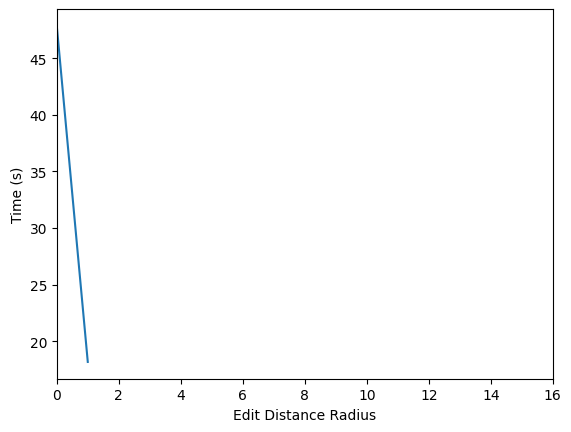

In [234]:
xlabel("Edit Distance Radius")
xlim(0,16)
ylabel("Time (s)")
plot(times)

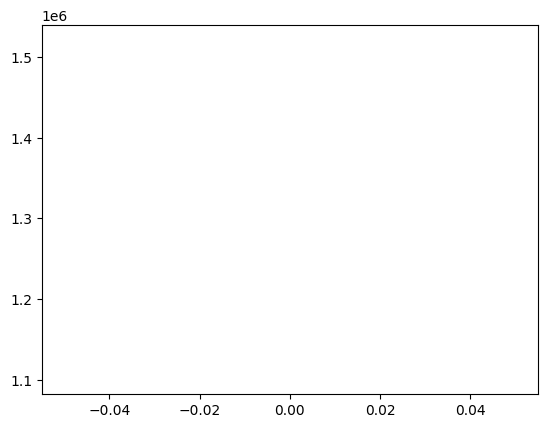

In [235]:
plot(swells)
plot(dag_sizes)

In [236]:
# Edit distance hints - ???
#hints = [context.add_expr(all_edits + f" <= {i}") for i in range(max_distance)]

In [61]:
designs = context.exist(nexts + prevs, reachable)

In [62]:
designs.dag_size

351416

In [63]:
designs.count()

1307674368000.0

In [64]:
good_designs = context.exist(nexts + prevs, reachable & end_reachable)

In [74]:
good_designs.count()

33791040.0

In [65]:
#show_design(context.pick(good_designs))

In [66]:
#good_designs2 = context.exist(nexts + prevs, reachable & end_reachable)

In [67]:
#approx_designs = good_designs & ~good_designs2

In [68]:
#approx_designs.count()

In [69]:
#show_design(context.pick(approx_designs))

In [70]:
#context.count(good_designs), context.count(good_designs2)

In [71]:
good_designs.dag_size

621970

In [76]:
good_designs.dag_size / reachable.dag_size

0.018396995430521992

In [72]:
good_designs.dag_size / designs.dag_size

1.7698966467093131

In [73]:
good_designs.count() / designs.count()

2.584056155484727e-05

In [77]:
designs.count() / good_designs.count()

38698.84939913066

In [75]:
context.bdd.dump("../../output/good_designs_without_space_jump.dddmp", [good_designs])

In [95]:
#TODO: "separable trans"
#TODO: git push
#TODO: n_restricted = 1
#TODO: does restricting/unrestricting space jump make a big difference in compute time?
#TODO: colab pro
#TODO: try a transpose representation where each item says what location it is at.
#TODO: Look at nexts in reachable support (this is probably a bug)
#TODO: one-hot location in conjunction with separability

#TODO: just check how much restricting the design space based on the abstraction helps (e.g. for ED 7)
#TODO: use context.forall to find the edges that are NOT design-conditional
# Then compute the "fully unconditional" trans closure... then do the exact same thing we have been doing

In [39]:
# Design
# Item
# Location

# Mess with the order
#def static_order_score(name):
#    var,tense,bit = name.rsplit('_', 2)
#    bit = int(bit)
#    is_design = var.startswith("major") or var.startswith("minor")
#    is_loc = var.startswith("node_id")
#    return (is_design, not is_loc, var, -bit, tense)

#context.bdd.configure(reordering=False)
#order = {v:i for i,v in enumerate(sorted(context.bdd.vars, key=static_order_score))}
#context.bdd.reorder()

In [40]:
# original_design = context.true
# for room_name, room in design["Rooms"].items():
#     for node_name, d in room["Drops"].items():
#         name = room_name + "_" + node_name
#         if d in major_items:
#             if name in major_drop_nodes:
#                 original_design &= context.add_expr(f"major_drop_{name} = {major_items.index(d)}")
#         if d in minor_items:
#             if name in minor_drop_nodes:
#                 original_design &= context.add_expr(f"minor_drop_{name} = {minor_items.index(d)}")